Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.png)

# Automated Machine Learning
_**Orange Juice Sales Forecasting**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Predict](#Predict)
1. [Operationalize](#Operationalize)

## Introduction
In this example, we use AutoML to train, select, and operationalize a time-series forecasting model for multiple time-series.

Make sure you have executed the [configuration notebook](../../../configuration.ipynb) before running this notebook.

The examples in the follow code samples use the University of Chicago's Dominick's Finer Foods dataset to forecast orange juice sales. Dominick's was a grocery chain in the Chicago metropolitan area.

## Setup

In [1]:
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from sklearn.metrics import mean_absolute_error, mean_squared_error

W0918 12:20:15.691082 140082692052736 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0918 12:20:15.692417 140082692052736 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.



As part of the setup you have already created a <b>Workspace</b>. To run AutoML, you also need to create an <b>Experiment</b>. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem. 

In [2]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'trottinettes-forecasting'
# project folder
project_folder = './accidents/trottinettes-forecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.53
Subscription ID,f80606e5-788f-4dc3-a9ea-2eb9a7836082
Workspace,eacbmlservicews
Resource Group,adlsgen2
Location,westus2
Project Directory,./accidents/trottinettes-forecasting
Run History Name,trottinettes-forecasting


## Data
You are now ready to load the historical orange juice sales data. We will load the CSV file into a plain pandas DataFrame; the time column in the CSV is called _WeekStarting_, so it will be specially parsed into the datetime type.

In [3]:
time_column_name = 'date'
data = pd.read_csv("trottinettes.tsv", sep='\t', parse_dates=[time_column_name])
print(data.shape)
data.head()

(96, 3)


,accidents,date,name
0,13,2010-01-01,trottinette
1,11,2010-02-01,trottinette
2,19,2010-03-01,trottinette
3,16,2010-04-01,trottinette
4,22,2010-05-01,trottinette


Each row in the DataFrame holds a quantity of weekly sales for an OJ brand at a single store. The data also includes the sales price, a flag indicating if the OJ brand was advertised in the store that week, and some customer demographic information based on the store location. For historical reasons, the data also include the logarithm of the sales quantity. The Dominick's grocery data is commonly used to illustrate econometric modeling techniques where logarithms of quantities are generally preferred.    

The task is now to build a time-series model for the _Quantity_ column. It is important to note that this dataset is comprised of many individual time-series - one for each unique combination of _Store_ and _Brand_. To distinguish the individual time-series, we thus define the **grain** - the columns whose values determine the boundaries between time-series: 

In [4]:
grain_column_names = ['name']
nseries = data.groupby(grain_column_names).ngroups
print('Data contains {0} individual time-series.'.format(nseries))

Data contains 1 individual time-series.


### Data Splitting
We now split the data into a training and a testing set for later forecast evaluation. The test set will contain the final 20 weeks of observed sales for each time-series. The splits should be stratified by series, so we use a group-by statement on the grain columns.

In [21]:
n_test_periods = 12

def split_last_n_by_grain(df, n):
    """Group df by grain and split on last n rows for each group."""
    df_grouped = (df.sort_values(time_column_name) # Sort by ascending time
                  .groupby(grain_column_names, group_keys=False))
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-n])
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-n:])
    return df_head, df_tail

X_train, X_test = split_last_n_by_grain(data, n_test_periods)

In [22]:
print(X_train.shape)
print(X_test.shape)

(84, 3)
(12, 3)


## Modeling

For forecasting tasks, AutoML uses pre-processing and estimation steps that are specific to time-series. AutoML will undertake the following pre-processing steps:
* Detect time-series sample frequency (e.g. hourly, daily, weekly) and create new records for absent time points to make the series regular. A regular time series has a well-defined frequency and has a value at every sample point in a contiguous time span 
* Impute missing values in the target (via forward-fill) and feature columns (using median column values) 
* Create grain-based features to enable fixed effects across different series
* Create time-based features to assist in learning seasonal patterns
* Encode categorical variables to numeric quantities

AutoML will currently train a single, regression-type model across **all** time-series in a given training set. This allows the model to generalize across related series.

You are almost ready to start an AutoML training job. First, we need to separate the target column from the rest of the DataFrame: 

In [23]:
target_column_name = 'accidents'
y_train = X_train.pop(target_column_name).values

## Train

The AutoMLConfig object defines the settings and data for an AutoML training job. Here, we set necessary inputs like the task type, the number of AutoML iterations to try, the training data, and cross-validation parameters. 

For forecasting tasks, there are some additional parameters that can be set: the name of the column holding the date/time, the grain column names, and the maximum forecast horizon. A time column is required for forecasting, while the grain is optional. If a grain is not given, AutoML assumes that the whole dataset is a single time-series. We also pass a list of columns to drop prior to modeling. The _logQuantity_ column is completely correlated with the target quantity, so it must be removed to prevent a target leak.

The forecast horizon is given in units of the time-series frequency; for instance, the OJ series frequency is weekly, so a horizon of 20 means that a trained model will estimate sales up-to 20 weeks beyond the latest date in the training data for each series. In this example, we set the maximum horizon to the number of samples per series in the test set (n_test_periods). Generally, the value of this parameter will be dictated by business needs. For example, a demand planning organizaion that needs to estimate the next month of sales would set the horizon accordingly. Please see the [energy_demand notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand) for more discussion of forecast horizon.

Finally, a note about the cross-validation (CV) procedure for time-series data. AutoML uses out-of-sample error estimates to select a best pipeline/model, so it is important that the CV fold splitting is done correctly. Time-series can violate the basic statistical assumptions of the canonical K-Fold CV strategy, so AutoML implements a [rolling origin validation](https://robjhyndman.com/hyndsight/tscv/) procedure to create CV folds for time-series data. To use this procedure, you just need to specify the desired number of CV folds in the AutoMLConfig object. It is also possible to bypass CV and use your own validation set by setting the *X_valid* and *y_valid* parameters of AutoMLConfig.

Here is a summary of AutoMLConfig parameters used for training the OJ model:

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**iterations**|Number of iterations. In each iteration, Auto ML trains a specific pipeline on the given data|
|**X**|Training matrix of features as a pandas DataFrame, shape = [n_training_samples, n_features]|
|**y**|Target values as a numpy.ndarray, shape = [n_training_samples, ]|
|**n_cross_validations**|Number of cross-validation folds to use for model/pipeline selection|
|**enable_voting_ensemble**|Allow AutoML to create a Voting ensemble of the best performing models
|**enable_stack_ensemble**|Allow AutoML to create a Stack ensemble of the best performing models
|**debug_log**|Log file path for writing debugging information
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|
|**time_column_name**|Name of the datetime column in the input data|
|**grain_column_names**|Name(s) of the columns defining individual series in the input data|
|**drop_column_names**|Name(s) of columns to drop prior to modeling|
|**max_horizon**|Maximum desired forecast horizon in units of time-series frequency|

In [24]:
time_series_settings = {
    'time_column_name': time_column_name,
    'grain_column_names': grain_column_names,
    'drop_column_names': [],
    'max_horizon': n_test_periods
}

automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl_trottinettes_errors.log',
                             primary_metric='normalized_mean_absolute_error',
                             iterations=10,
                             X=X_train,
                             y=y_train,
                             n_cross_validations=2,
                             enable_voting_ensemble=False,
                             enable_stack_ensemble=False,
                             path=project_folder,
                             verbosity=logging.INFO,
                             **time_series_settings)

You can now submit a new training run. For local runs, the execution is synchronous. Depending on the data and number of iterations this operation may take several minutes.
Information from each iteration will be printed to the console.

In [25]:
local_run = experiment.submit(automl_config, show_output=True)
# Duplicates in time and grain combinations
# The data provided is insufficient for training : The data points should have at least 43 for a valid training with cv 2, max_horizon 20, lags [0] and rolling window size 0. The current dataset has only 30 points.

Running on local machine
Parent Run ID: AutoML_707590aa-0240-4c61-808e-c715bea56b30
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.

### Retrieve the Best Model
Each run within an Experiment stores serialized (i.e. pickled) pipelines from the AutoML iterations. We can now retrieve the pipeline with the best performance on the validation dataset:

In [26]:
best_run, fitted_pipeline = local_run.get_output()

In [27]:
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
trottinettes-forecasting,AutoML_707590aa-0240-4c61-808e-c715bea56b30_3,,Completed,Link to Azure Portal,Link to Documentation


In [28]:
fitted_pipeline.steps

[('timeseriestransformer', TimeSeriesTransformer(logger=None,
                        pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('StandardScalerWrapper',
  <automl.client.core.common.model_wrappers.StandardScalerWrapper at 0x7f675972ca90>),
 ('ExtraTreesRegressor',
  ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features=0.3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.001953125,
                      min_samples_split=0.00310675990983383,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False))]

# Forecasting

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. First, we remove the target values from the test set:

In [29]:
y_test = X_test.pop(target_column_name).values

In [30]:
X_test.head(12)

,date,name
84,2017-01-01,trottinette
85,2017-02-01,trottinette
86,2017-03-01,trottinette
87,2017-04-01,trottinette
88,2017-05-01,trottinette
89,2017-06-01,trottinette
90,2017-07-01,trottinette
91,2017-08-01,trottinette
92,2017-09-01,trottinette
93,2017-10-01,trottinette


In [31]:
y_test

array([19, 11, 24, 27, 21, 41, 27, 17, 30, 29, 23, 20])

To produce predictions on the test set, we need to know the feature values at all dates in the test set. This requirement is somewhat reasonable for the OJ sales data since the features mainly consist of price, which is usually set in advance, and customer demographics which are approximately constant for each store over the 20 week forecast horizon in the testing data. 

We will first create a query `y_query`, which is aligned index-for-index to `X_test`. This is a vector of target values where each `NaN` serves the function of the question mark to be replaced by forecast. Passing definite values in the `y` argument allows the `forecast` function to make predictions on data that does not immediately follow the train data which contains `y`. In each grain, the last time point where the model sees a definite value of `y` is that grain's _forecast origin_.

In [32]:
# Replace ALL values in y_pred by NaN.
# The forecast origin will be at the beginning of the first forecast period.
# (Which is the same time as the end of the last training period.)
y_query = y_test.copy().astype(np.float)
y_query.fill(np.nan)
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_pred, X_trans = fitted_pipeline.forecast(X_test, y_query)

If you are used to scikit pipelines, perhaps you expected `predict(X_test)`. However, forecasting requires a more general interface that also supplies the past target `y` values. Please use `forecast(X,y)` as `predict(X)` is reserved for internal purposes on forecasting models.

The [energy demand forecasting notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand) demonstrates the use of the forecast function in more detail in the context of using lags and rolling window features. 

In [35]:
y_pred

array([18.2 , 17.55, 24.15, 18.2 , 19.  , 27.3 , 20.2 , 16.8 , 30.  ,
       21.  , 12.9 , 19.9 ])

# Evaluate

To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE). 

It is a good practice to always align the output explicitly to the input, as the count and order of the rows may have changed during transformations that span multiple rows.

In [36]:
def align_outputs(y_predicted, X_trans, X_test, y_test, predicted_column_name = 'predicted'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods in y
    """
    
    df_fcst = pd.DataFrame({predicted_column_name : y_predicted})
    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index
    
    # align original X_test to y_test    
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's index does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')
    
    # drop rows where prediction or actuals are nan 
    # happens because of missing actuals 
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name, predicted_column_name]].notnull().all(axis=1)]
    return(clean)

df_all = align_outputs(y_pred, X_trans, X_test, y_test)

In [37]:
def MAPE(actual, pred):
    """
    Calculate mean absolute percentage error.
    Remove NA and values where actual is close to zero
    """
    not_na = ~(np.isnan(actual) | np.isnan(pred))
    not_zero = ~np.isclose(actual, 0.0)
    actual_safe = actual[not_na & not_zero]
    pred_safe = pred[not_na & not_zero]
    APE = 100*np.abs((actual_safe - pred_safe)/actual_safe)
    return np.mean(APE)

Simple forecasting model
[Test Data] 
Root Mean squared error: 6.61
mean_absolute_error score: 4.77
MAPE: 19.86


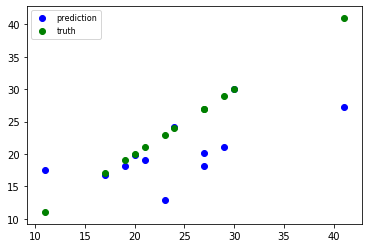

In [38]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_all[target_column_name], df_all['predicted']))

# Plot outputs
import matplotlib.pyplot as plt

%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

# Operationalize

_Operationalization_ means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.

In [39]:
description = 'AutoML trottinettes forecaster'
tags = None
model = local_run.register_model(description = description, tags = tags)

print(local_run.model_id)

Registering model AutoML707590aa0best
AutoML707590aa0best


### Develop the scoring script

Serializing and deserializing complex data frames may be tricky. We first develop the `run()` function of the scoring script locally, then write it into a scoring script. It is much easier to debug any quirks of the scoring function without crossing two compute environments. For this exercise, we handle a common quirk of how pandas dataframes serialize time stamp values.

In [41]:
# this is where we test the run function of the scoring script interactively
# before putting it in the scoring script

timestamp_columns = ['date']

def run(rawdata, test_model = None):
    """
    Intended to process 'rawdata' string produced by
    
    {'X': X_test.to_json(), y' : y_test.to_json()}
    
    Don't convert the X payload to numpy.array, use it as pandas.DataFrame
    """
    try:
        # unpack the data frame with timestamp        
        rawobj = json.loads(rawdata)                    # rawobj is now a dict of strings        
        X_pred = pd.read_json(rawobj['X'], convert_dates=False)   # load the pandas DF from a json string
        for col in timestamp_columns:                             # fix timestamps
            X_pred[col] = pd.to_datetime(X_pred[col], unit='ms') 
        
        y_pred = np.array(rawobj['y'])                    # reconstitute numpy array from serialized list
        
        if test_model is None:
            result = model.forecast(X_pred, y_pred)       # use the global model from init function
        else:
            result = test_model.forecast(X_pred, y_pred)  # use the model on which we are testing
        
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    
    forecast_as_list = result[0].tolist()
    index_as_df = result[1].index.to_frame().reset_index(drop=True)
    
    return json.dumps({"forecast": forecast_as_list,   # return the minimum over the wire: 
                       "index": index_as_df.to_json()  # no forecast and its featurized values
                      })

In [42]:
# test the run function here before putting in the scoring script
import json

test_sample = json.dumps({'X': X_test.to_json(), 'y' : y_query.tolist()})
response = run(test_sample, fitted_pipeline)

# unpack the response, dealing with the timestamp serialization again
res_dict = json.loads(response)
y_fcst_all = pd.read_json(res_dict['index'])
y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
y_fcst_all['forecast'] = res_dict['forecast']
y_fcst_all.head()

,date,name,forecast
0,2017-01-01,trottinette,18.20
1,2017-02-01,trottinette,17.55
10,2017-11-01,trottinette,24.15
11,2017-12-01,trottinette,18.20
2,2017-03-01,trottinette,19.00


Now that the function works locally in the notebook, let's write it down into the scoring script. The scoring script is authored by the data scientist. Adjust it to taste, adding inputs, outputs and processing as needed.

In [43]:
%%writefile score_fcast.py
import pickle
import json
import numpy as np
import pandas as pd
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model


def init():
    global model
    model_path = Model.get_model_path(model_name = '<<modelid>>') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

timestamp_columns = ['date']

def run(rawdata, test_model = None):
    """
    Intended to process 'rawdata' string produced by
    
    {'X': X_test.to_json(), y' : y_test.to_json()}
    
    Don't convert the X payload to numpy.array, use it as pandas.DataFrame
    """
    try:
        # unpack the data frame with timestamp        
        rawobj = json.loads(rawdata)                    # rawobj is now a dict of strings        
        X_pred = pd.read_json(rawobj['X'], convert_dates=False)   # load the pandas DF from a json string
        for col in timestamp_columns:                             # fix timestamps
            X_pred[col] = pd.to_datetime(X_pred[col], unit='ms') 
        
        y_pred = np.array(rawobj['y'])                    # reconstitute numpy array from serialized list
        
        if test_model is None:
            result = model.forecast(X_pred, y_pred)       # use the global model from init function
        else:
            result = test_model.forecast(X_pred, y_pred)  # use the model on which we are testing
        
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    
    # prepare to send over wire as json
    forecast_as_list = result[0].tolist()
    index_as_df = result[1].index.to_frame().reset_index(drop=True)
    
    return json.dumps({"forecast": forecast_as_list,   # return the minimum over the wire: 
                       "index": index_as_df.to_json()  # no forecast and its featurized values
                      })

Overwriting score_fcast.py


In [44]:
# get the model
from azureml.train.automl.run import AutoMLRun

experiment = Experiment(ws, experiment_name)
ml_run = AutoMLRun(experiment = experiment, run_id = local_run.id)
best_iteration = int(str.split(best_run.id,'_')[-1])      # the iteration number is a postfix of the run ID.

In [45]:
# get the best model's dependencies and write them into this file
from azureml.core.conda_dependencies import CondaDependencies

conda_env_file_name = 'fcast_env.yml'

dependencies = ml_run.get_run_sdk_dependencies(iteration = best_iteration)
for p in ['azureml-train-automl', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'], pip_packages=['azureml-train-automl'])

myenv.save_to_file('.', conda_env_file_name)

azureml-train-automl	1.0.53
azureml-core	1.0.53


'fcast_env.yml'

In [46]:
# this is the script file name we wrote a few cells above
script_file_name = 'score_fcast.py'

# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-train-automl']))

# Substitute the actual model id in the script file.

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelid>>', local_run.model_id))

### Create a Container Image

In [47]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'type': "automl-forecasting"},
                                 description = "Image for automl forecasting sample")

image = Image.create(name = "automl-fcast-image",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

if image.creation_state == 'Failed':
    print("Image build log at: " + image.image_build_log_uri)

Creating image
Running...................................................
Succeeded
Image creation operation finished for image automl-fcast-image:1, operation "Succeeded"


### Deploy the Image as a Web Service on Azure Container Instance

In [48]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': "automl-forecasting"},
                                               description = "Automl forecasting sample service")

In [49]:
from azureml.core.webservice import Webservice

aci_service_name = 'automl-forecast-01'
print(aci_service_name)

aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-forecast-01
Creating service
Running.....................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


### Call the service

In [50]:
# we send the data to the service serialized into a json string
test_sample = json.dumps({'X':X_test.to_json(), 'y' : y_query.tolist()})
response = aci_service.run(input_data = test_sample)

# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.read_json(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)

In [51]:
y_fcst_all.head(12)

,date,name,forecast
0,2017-01-01,trottinette,18.20
1,2017-02-01,trottinette,17.55
10,2017-11-01,trottinette,24.15
11,2017-12-01,trottinette,18.20
2,2017-03-01,trottinette,19.00
3,2017-04-01,trottinette,27.30
4,2017-05-01,trottinette,20.20
5,2017-06-01,trottinette,16.80
6,2017-07-01,trottinette,30.00
7,2017-08-01,trottinette,21.00


### Delete the web service if desired

In [ ]:
serv = Webservice(ws, 'automl-forecast-01')
# serv.delete()     # don't do it accidentally